In [100]:
import numpy as np
import utils
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from math import log2
from scipy.special import expit
from scipy.ndimage.filters import gaussian_filter1d
import seaborn as sns
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 200
sns.set_theme()

In [101]:
train_size = 60000
test_size = 10000
data = utils.read_mnist_image(
    "datasets/train-images-idx3-ubyte.gz",
    28,
    28,
    train_size,
)
labels = utils.read_mnist_label(
    "datasets/train-labels-idx1-ubyte.gz",
    train_size,
)

data_test = utils.read_mnist_image(
    "datasets/t10k-images-idx3-ubyte.gz",
    28,
    28,
    test_size,
)
labels_test = utils.read_mnist_label(
    "datasets/t10k-labels-idx1-ubyte.gz",
    test_size,
)

In [102]:
class nn_one_layer:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.W1 = 0.01 * np.random.randn(input_size, hidden_size)
        self.W2 = 0.01 * np.random.randn(hidden_size, output_size)

    def forward(self, u):
        z = np.matmul(u, self.W1)
        h = self.sigmoid(z)
        v = np.matmul(h, self.W2)
        return v, h, z

    def sigmoid(self, a):
        return expit(a)

    def sigmoid_prime(self, a):
        dsigmoid_da = self.sigmoid(a) * (1 - self.sigmoid(a))
        return dsigmoid_da

    def loss_mse(self, preds, targets):
        loss = np.sum((preds - targets) ** 2)
        return 0.5 * loss

    def loss_deriv(self, preds, targets):
        dL_dPred = preds - targets
        return dL_dPred

    def backprop(self, W1, W2, dL_dPred, U, H, Z, activate=True, prob_not_backprop=0):
        dL_dW2 = np.matmul(H.T, dL_dPred)

        if np.random.uniform() > prob_not_backprop:
            dL_dH = np.matmul(dL_dPred, W2.T)
            if activate:
                dL_dZ = np.multiply(self.sigmoid_prime(Z), dL_dH)
            else:
                dL_dZ = dL_dH
            dL_dW1 = np.matmul(U.T, dL_dZ)
        else:
            dL_dH = 1
            dL_dZ = dL_dH
            dL_dW1 = U.T

        return dL_dW1, dL_dW2, dL_dZ, dL_dH


In [103]:
input_size = 784
hidden_size = 30
output_size = 10

W1_fixed_feedback = 0.1 * np.random.randn(input_size, hidden_size)
W2_fixed_feedback = 0.1 * np.random.randn(hidden_size, output_size)


def compute_accuracy(preds, targets):
    assert len(preds) == len(targets)
    preds = np.argmax(preds, axis=1)
    targets = np.argmax(targets, axis=1)
    return float((targets == preds).sum()) / len(targets)


class Trainer:
    def __init__(
        self,
        model,
        data,
        labels,
        data_test,
        labels_test,
        batch_size=256,
        weight_transport=True,
        activation_derivative=True,
        prob_not_backprop=0,
    ):
        self.model = model
        self.data = data
        self.labels = labels
        self.data_test = data_test
        self.labels_test = labels_test
        self.batch_size = batch_size
        self.weight_transport = weight_transport
        self.activation_derivative = activation_derivative
        self.prob_not_backprop = prob_not_backprop

    def generate_batch(self, inputs, targets):
        assert len(inputs) == len(targets)
        rng = np.random.default_rng()
        rand_inds = rng.choice(
            np.arange(0, len(inputs)), size=self.batch_size, replace=False
        )
        inputs_batch = inputs[rand_inds]
        targets_batch = targets[rand_inds]
        return inputs_batch, targets_batch

    def train_one_batch(self, lr):
        inputs, targets = self.generate_batch(self.data, self.labels)
        preds, H, Z = self.model.forward(inputs)


        loss = self.model.loss_mse(preds, targets) / len(preds)
        accuracy = compute_accuracy(preds, targets)

        dL_dPred = self.model.loss_deriv(preds, targets)

        W1_feedback = self.model.W1
        W2_feedback = self.model.W2

        if not self.weight_transport:
            W1_feedback = W1_fixed_feedback
            W2_feedback = W2_fixed_feedback

        dL_dW1, dL_dW2, dL_dZ, dL_DH = self.model.backprop(
            W1_feedback,
            W2_feedback,
            dL_dPred,
            U=inputs,
            H=H,
            Z=Z,
            activate=self.activation_derivative,
            prob_not_backprop=self.prob_not_backprop
        )
        self.model.W1 -= lr * dL_dW1
        self.model.W2 -= lr * dL_dW2
        return (loss, accuracy, dL_dZ, dL_DH)


    def validate(self, step):
        preds, H, Z = self.model.forward(self.data_test)
        loss_test = self.model.loss_mse(preds, self.labels_test) / len(preds)
        accuracy_test = compute_accuracy(preds, self.labels_test)

        print(
            f"epoch: {step}, loss_validation: {loss_test}, accuracy_validation: {accuracy_test}"
        )
        return (
            loss_test,
            accuracy_test,
        )

    def test(self, nn, inputs, targets):
        preds, H, Z = nn.forward(inputs)
        loss = nn.loss_mse(preds, targets) / len(preds)
        accuracy = compute_accuracy(preds, targets)
        return loss, accuracy

    def train(
        self,
        nbatches=10000,
        lr=0.000005,
        validation_frequency=100,
    ):
        xs = np.arange(nbatches)
        losses = np.zeros(nbatches).astype(np.double)
        accuracies = np.zeros(nbatches).astype(np.double)
        weights1 = np.zeros((nbatches, self.model.input_size, self.model.hidden_size))
        weights2 = np.zeros((nbatches, self.model.hidden_size, self.model.output_size))
        dL_dZs = np.zeros((nbatches, self.batch_size, self.model.hidden_size))
        dL_dHs = np.zeros((nbatches, self.batch_size, self.model.hidden_size))

        losses_test = np.zeros(nbatches).astype(np.double)
        accuracies_test = np.zeros(nbatches).astype(np.double)

        for i in range(nbatches):
            loss, accuracy, dL_dZ, dL_dH = self.train_one_batch(lr)
            losses[i] = loss
            accuracies[i] = accuracy
            weights1[i] = self.model.W1
            weights2[i] = self.model.W2
            dL_dZs = dL_dZ
            dL_dHs = dL_dH

            loss_test = None
            accuracy_test = None
            if ((i + 1) % validation_frequency) == 0:
                loss_test, accuracy_test = self.validate(i)

            losses_test[i] = loss_test
            accuracies_test[i] = accuracy_test

        return {
            "loss": {
                "train": losses,
                "test": losses_test,
            },
            "accuracy": {
                "train": accuracies,
                "test": accuracies_test,
            },
            "weights": {
                "W1": {
                    "train": weights1
                },
                "W2": {
                    "train": weights2
                }
            },
            "gradient_terms": {
                "dL_dZ": {
                    "train": dL_dZs
                },
                "dL_dH": {
                    "train": dL_dHs
                },
            }
        }


In [104]:
results = Trainer(
    model=nn_one_layer(input_size, hidden_size, output_size),
    data=data,
    labels=labels,
    data_test=data_test,
    labels_test=labels_test,
    weight_transport=True,
    activation_derivative=True,
    prob_not_backprop=0
).train()

results_nwt = Trainer(
    model=nn_one_layer(input_size, hidden_size, output_size),
    data=data,
    labels=labels,
    data_test=data_test,
    labels_test=labels_test,
    weight_transport=False,
    activation_derivative=True,
    prob_not_backprop=0
).train()

results_nad = Trainer(
    model=nn_one_layer(input_size, hidden_size, output_size),
    data=data,
    labels=labels,
    data_test=data_test,
    labels_test=labels_test,
    weight_transport=True,
    activation_derivative=False,
    prob_not_backprop=0
).train()

results_nwt_nad = Trainer(
    model=nn_one_layer(input_size, hidden_size, output_size),
    data=data,
    labels=labels,
    data_test=data_test,
    labels_test=labels_test,
    weight_transport=False,
    activation_derivative=False,
    prob_not_backprop=0
).train()

epoch: 99, loss_validation: 0.43108049748440536, accuracy_validation: 0.3438
epoch: 199, loss_validation: 0.4107636730625018, accuracy_validation: 0.4578
epoch: 299, loss_validation: 0.39525732666429264, accuracy_validation: 0.5305
epoch: 399, loss_validation: 0.3811089163345037, accuracy_validation: 0.5743
epoch: 499, loss_validation: 0.3679904355976887, accuracy_validation: 0.5986
epoch: 599, loss_validation: 0.35605355347251677, accuracy_validation: 0.6121
epoch: 699, loss_validation: 0.3454102911818039, accuracy_validation: 0.6204
epoch: 799, loss_validation: 0.3357966136984829, accuracy_validation: 0.635
epoch: 899, loss_validation: 0.3271027517377244, accuracy_validation: 0.6394
epoch: 999, loss_validation: 0.319008909064539, accuracy_validation: 0.6455
epoch: 1099, loss_validation: 0.3113435731895668, accuracy_validation: 0.6577
epoch: 1199, loss_validation: 0.3042537252016074, accuracy_validation: 0.6611
epoch: 1299, loss_validation: 0.29774869249203423, accuracy_validation: 0.

In [105]:
def plot_loss(values, titles):
    colors = list(mcolors.TABLEAU_COLORS.values())
    for i, ys in enumerate(values):
        xs = np.arange(len(ys["train"]))
        losses = ys["train"]
        losses_test = ys["test"]
        plt.plot(xs, losses, alpha=0.2, color=colors[i])
        # plt.plot(xs, gaussian_filter1d(losses, 5), label=f"{titles[i]}", color=colors[i])
        plt.plot(
            xs[np.isfinite(losses_test)],
            losses_test[np.isfinite(losses_test)],
            label=f"{titles[i]}",
            color=colors[i]
        )
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.ylim(bottom=0)
    plt.legend()
    plt.show()


def plot_accuracy(values, titles):
    colors = list(mcolors.TABLEAU_COLORS.values())
    for i, ys in enumerate(values):
        xs = np.arange(len(ys["train"]))
        accuracies = ys["train"]
        accuracies_test = ys["test"]
        plt.plot(xs, accuracies, alpha=0.2, color=colors[i])
        # plt.plot(xs, gaussian_filter1d(accuracies, 5), label=f"{titles[i]}", color=colors[i])
        plt.plot(
            xs[np.isfinite(accuracies_test)],
            accuracies_test[np.isfinite(accuracies_test)],
            label=f"{titles[i]}",
            color=colors[i]
        )
    plt.xlabel("Epoch")
    plt.ylabel("Raw Accuracy")
    plt.ylim((0, 1))
    plt.legend()
    plt.show()

def plot_weights(values, titles):
    colors = list(mcolors.TABLEAU_COLORS.values())
    for i, ys in enumerate(values):
        w1 = np.diff(ys["W1"]["train"].mean(axis=1).mean(axis=1))
        w2 = np.diff(ys["W2"]["train"].mean(axis=1).mean(axis=1))
        xs = np.arange(len(w1 - 1))
        plt.plot(xs, w1, label="W1")
        plt.plot(xs, w2, label="W2")
    plt.xlabel("Epoch")
    plt.ylabel("Mean connection weight change")
    plt.legend()
    plt.show()

def plot_inbetweens(values, titles):
    for i, ys in enumerate(values):
        dlz = ys["dL_dZ"]["train"].mean(axis=1)
        dlh = ys["dL_dH"]["train"].mean(axis=1)
        xs = np.arange(len(dlz - 1))
        plt.plot(xs, dlz, label="dL_dZ")
        plt.plot(xs, dlh, label="dL_dH")
    plt.xlabel("Epoch")
    plt.ylabel("Differential")
    plt.legend()
    plt.show()

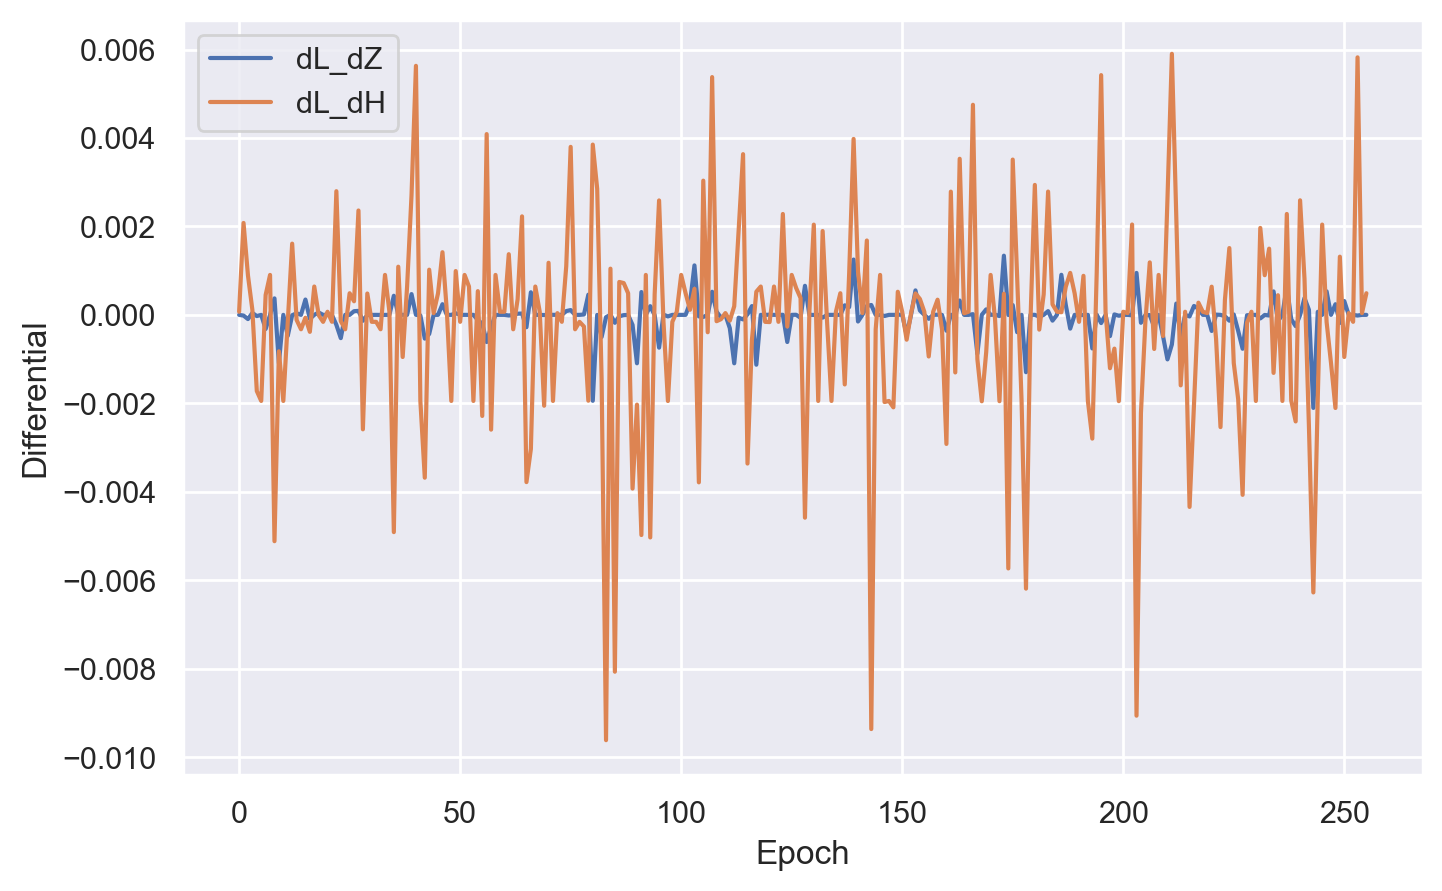

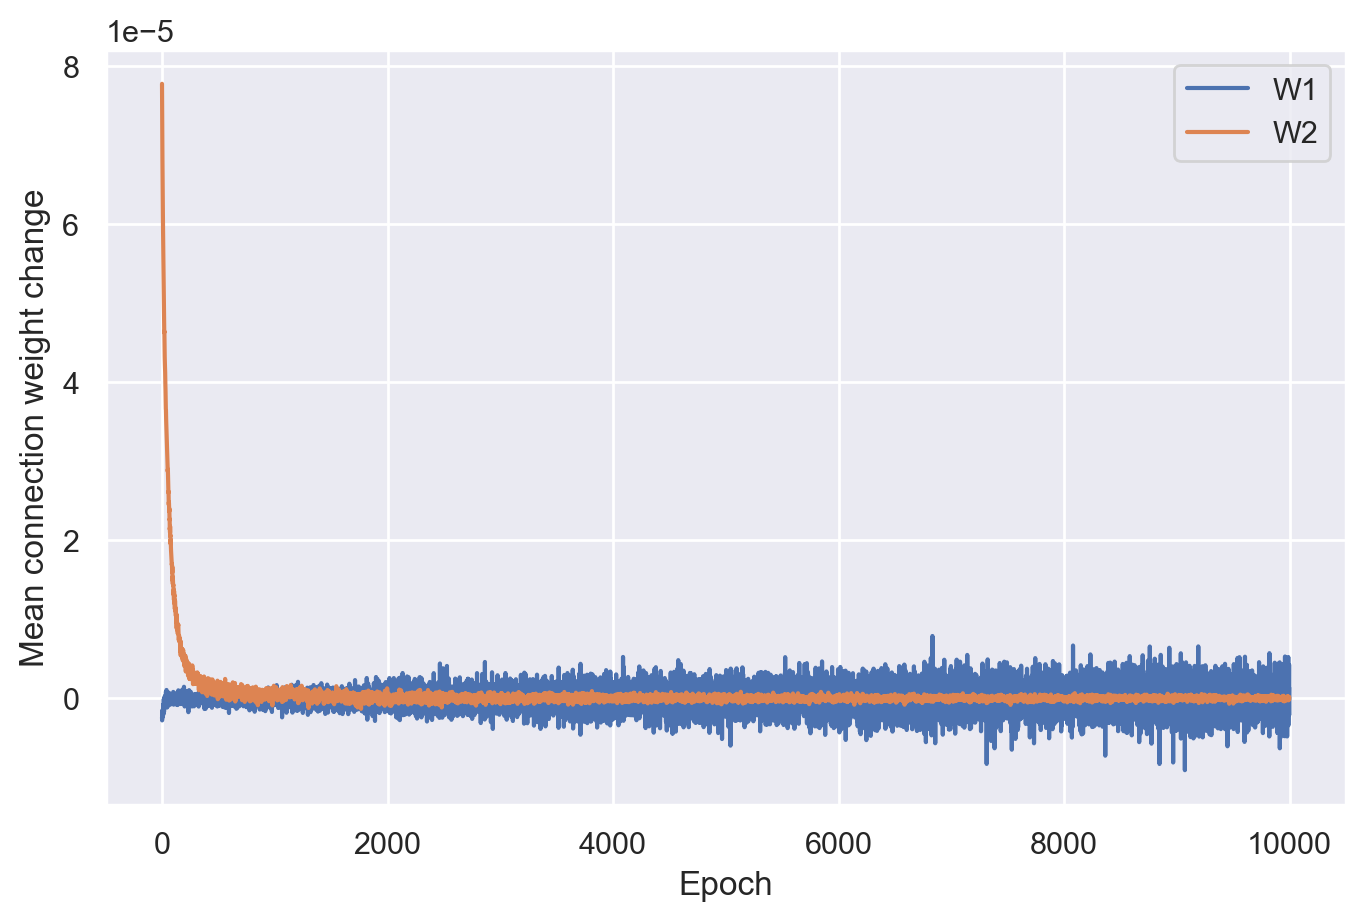

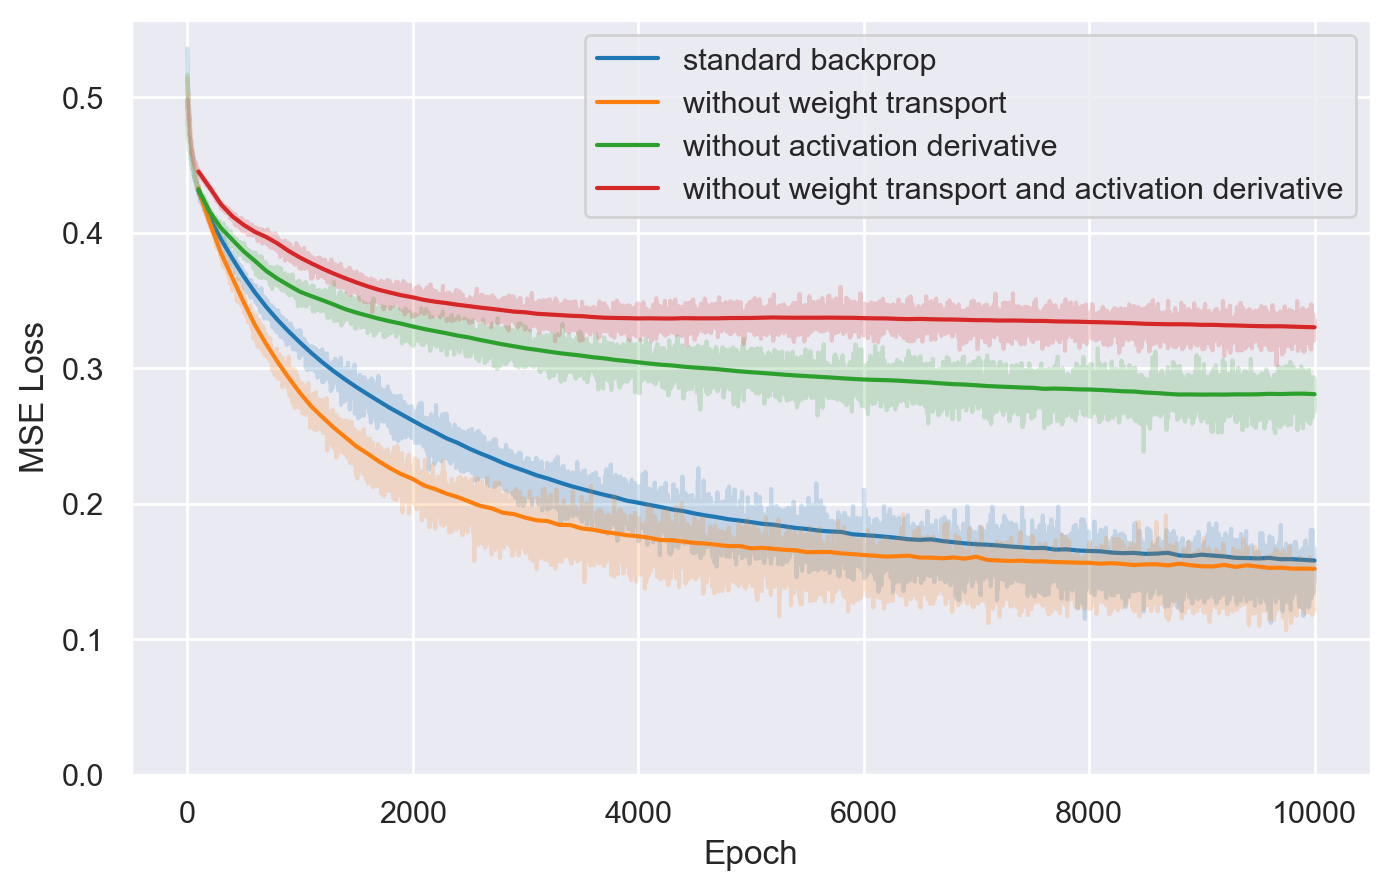

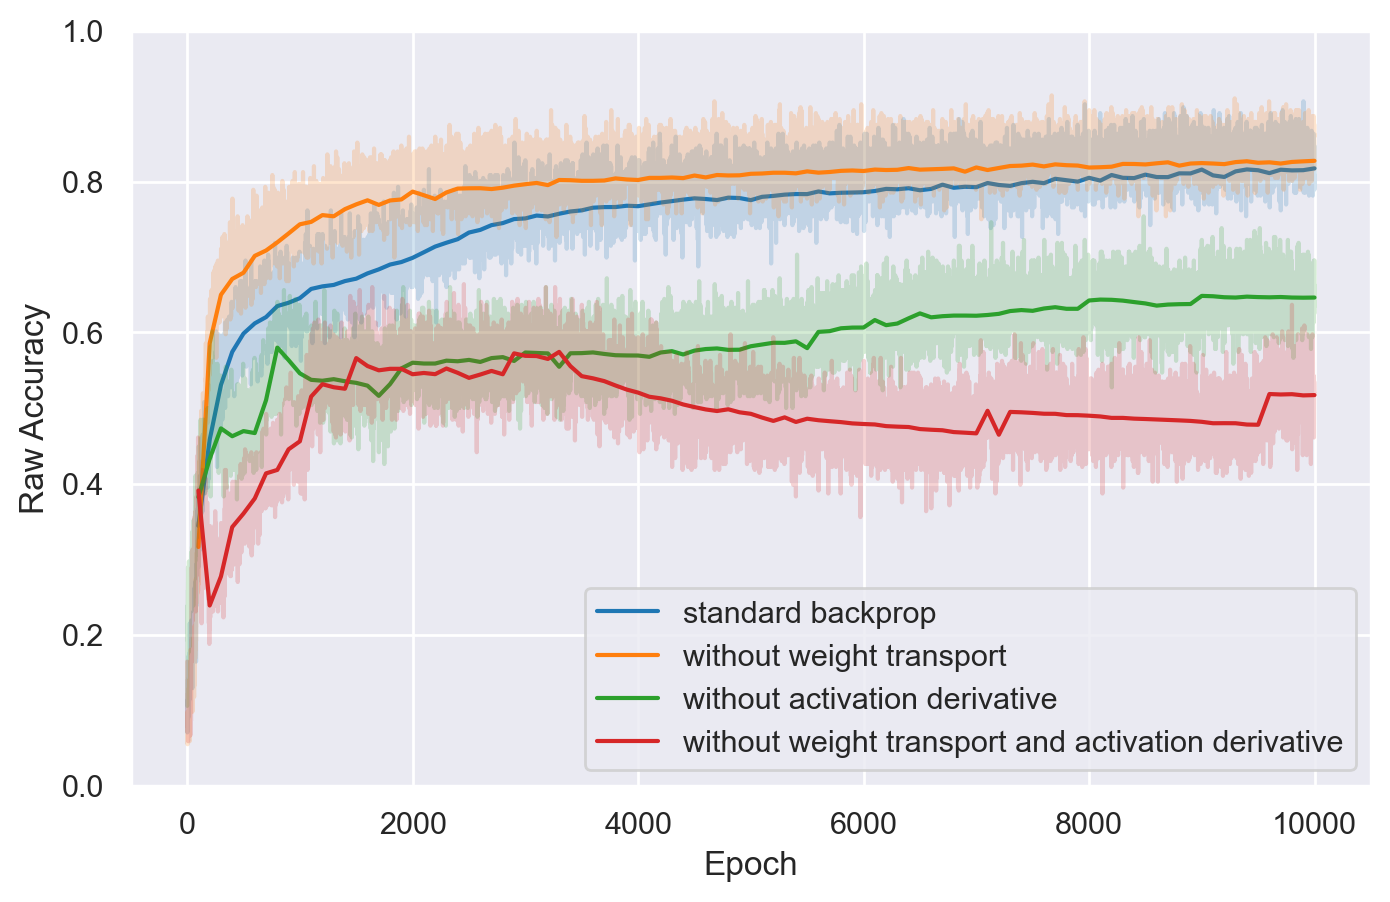

In [114]:
plot_inbetweens([results["gradient_terms"]], [""])

plot_weights([results["weights"]], ["weights"])

plot_loss(
    [
        results["loss"], 
        results_nwt["loss"], 
        results_nad["loss"], 
        results_nwt_nad["loss"]
    ], [
        'standard backprop', 
        'without weight transport', 
        'without activation derivative', 
        'without weight transport and activation derivative'
    ]
)

plot_accuracy(
    [
        results["accuracy"], 
        results_nwt["accuracy"], 
        results_nad["accuracy"], 
        results_nwt_nad["accuracy"]
    ], [
        'standard backprop', 
        'without weight transport', 
        'without activation derivative', 
        'without weight transport and activation derivative'
    ]
)

In [107]:
results_pnb3 = Trainer(
    model=nn_one_layer(input_size, hidden_size, output_size),
    data=data,
    labels=labels,
    data_test=data_test,
    labels_test=labels_test,
    weight_transport=True,
    activation_derivative=True,
    prob_not_backprop=0.3,
    batch_size=30
).train()

results_pnb5 = Trainer(
    model=nn_one_layer(input_size, hidden_size, output_size),
    data=data,
    labels=labels,
    data_test=data_test,
    labels_test=labels_test,
    weight_transport=True,
    activation_derivative=True,
    prob_not_backprop=0.5,
    batch_size=30
).train()

results_pnb7 = Trainer(
    model=nn_one_layer(input_size, hidden_size, output_size),
    data=data,
    labels=labels,
    data_test=data_test,
    labels_test=labels_test,
    weight_transport=True,
    activation_derivative=True,
    prob_not_backprop=0.7,
    batch_size=30
).train()

epoch: 99, loss_validation: 0.5, accuracy_validation: 0.1103
epoch: 199, loss_validation: 0.5, accuracy_validation: 0.1215
epoch: 299, loss_validation: 0.5, accuracy_validation: 0.1039
epoch: 399, loss_validation: 0.5, accuracy_validation: 0.1033
epoch: 499, loss_validation: 0.5, accuracy_validation: 0.1003
epoch: 599, loss_validation: 0.5, accuracy_validation: 0.1
epoch: 699, loss_validation: 0.5, accuracy_validation: 0.1
epoch: 799, loss_validation: 0.5, accuracy_validation: 0.1
epoch: 899, loss_validation: 0.5, accuracy_validation: 0.1
epoch: 999, loss_validation: 0.5, accuracy_validation: 0.1
epoch: 1099, loss_validation: 0.5, accuracy_validation: 0.1
epoch: 1199, loss_validation: 0.5, accuracy_validation: 0.1
epoch: 1299, loss_validation: 0.5, accuracy_validation: 0.1
epoch: 1399, loss_validation: 0.5, accuracy_validation: 0.1
epoch: 1499, loss_validation: 0.5, accuracy_validation: 0.1
epoch: 1599, loss_validation: 0.5, accuracy_validation: 0.1
epoch: 1699, loss_validation: 0.5, a

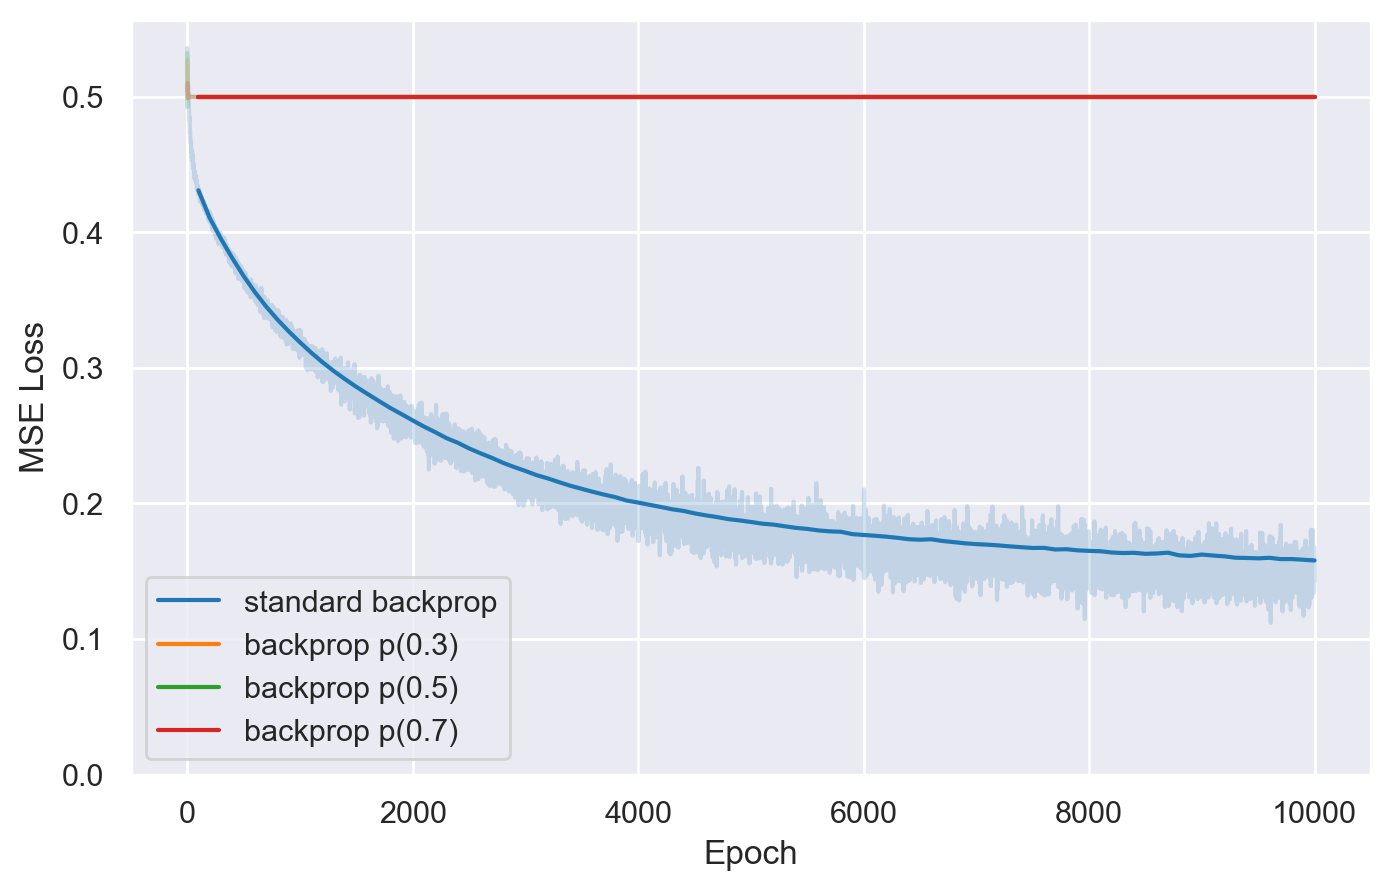

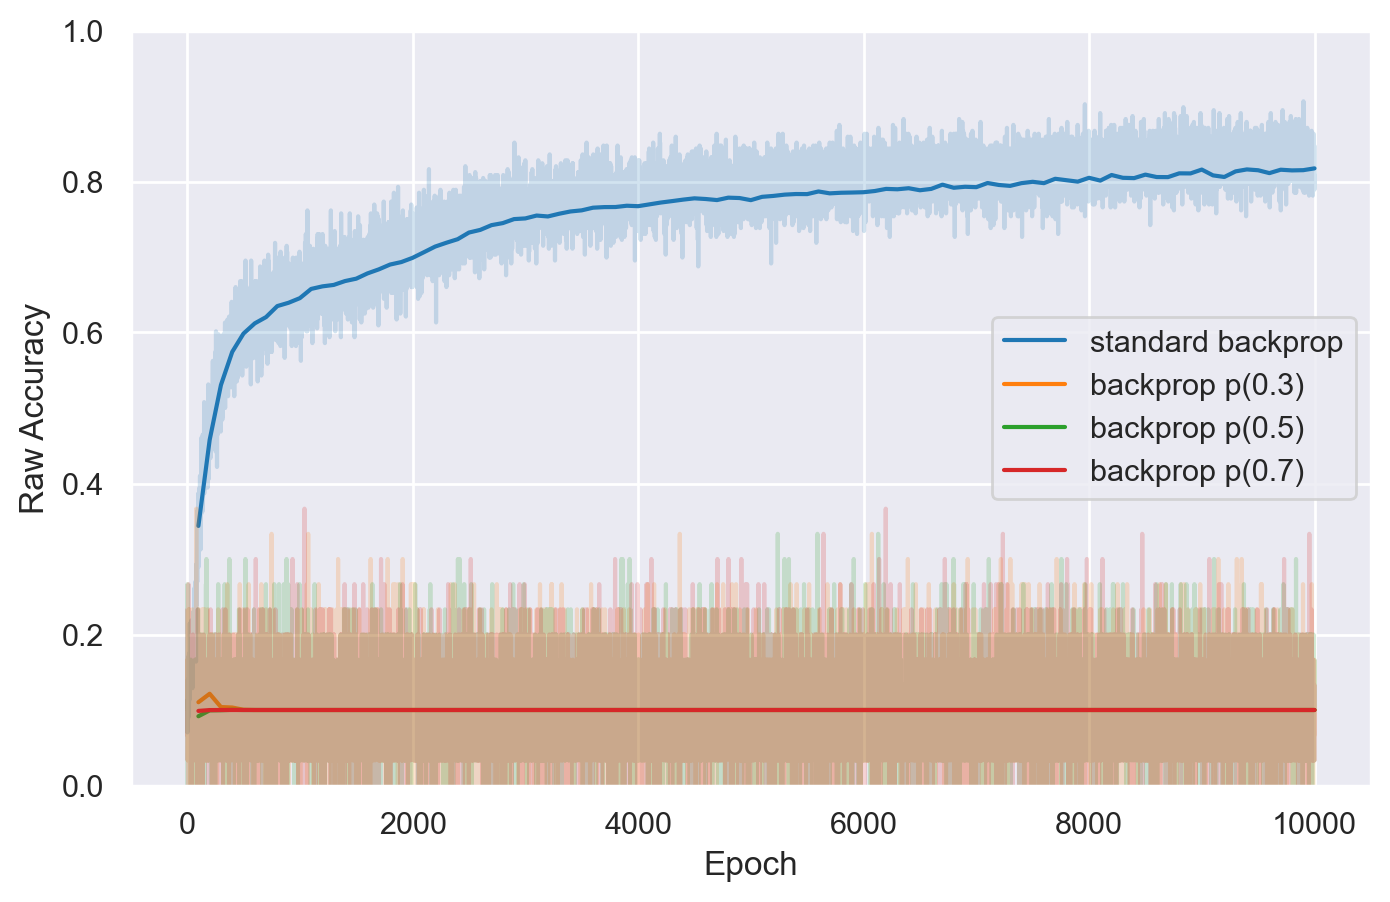

In [108]:
plot_loss(
    [
        results["loss"], 
        results_pnb3["loss"], 
        results_pnb5["loss"], 
        results_pnb7["loss"]
    ], [
        'standard backprop', 
        'backprop p(0.3)', 
        'backprop p(0.5)', 
        'backprop p(0.7)'
    ]
)

plot_accuracy(
    [
        results["accuracy"], 
        results_pnb3["accuracy"], 
        results_pnb5["accuracy"], 
        results_pnb7["accuracy"]
    ], [
        'standard backprop', 
        'backprop p(0.3)', 
        'backprop p(0.5)', 
        'backprop p(0.7)'
    ]
)

In [109]:
results_15 = Trainer(
    model=nn_one_layer(input_size, 15, output_size),
    data=data,
    labels=labels,
    data_test=data_test,
    labels_test=labels_test,
    weight_transport=True,
    activation_derivative=True,
    prob_not_backprop=0
).train()

results_30 = Trainer(
    model=nn_one_layer(input_size, 30, output_size),
    data=data,
    labels=labels,
    data_test=data_test,
    labels_test=labels_test,
    weight_transport=True,
    activation_derivative=True,
    prob_not_backprop=0
).train()

results_60 = Trainer(
    model=nn_one_layer(input_size, 60, output_size),
    data=data,
    labels=labels,
    data_test=data_test,
    labels_test=labels_test,
    weight_transport=True,
    activation_derivative=True,
    prob_not_backprop=0
).train()

results_120 = Trainer(
    model=nn_one_layer(input_size, 120, output_size),
    data=data,
    labels=labels,
    data_test=data_test,
    labels_test=labels_test,
    weight_transport=True,
    activation_derivative=True,
    prob_not_backprop=0
).train()

epoch: 99, loss_validation: 0.4528727573788057, accuracy_validation: 0.2577
epoch: 199, loss_validation: 0.42859234531684753, accuracy_validation: 0.4014
epoch: 299, loss_validation: 0.4139856580924231, accuracy_validation: 0.4355
epoch: 399, loss_validation: 0.4029793990098738, accuracy_validation: 0.441
epoch: 499, loss_validation: 0.3942656258314893, accuracy_validation: 0.4716
epoch: 599, loss_validation: 0.38707706381344875, accuracy_validation: 0.5419
epoch: 699, loss_validation: 0.3805284924178954, accuracy_validation: 0.558
epoch: 799, loss_validation: 0.37458029331977216, accuracy_validation: 0.5716
epoch: 899, loss_validation: 0.3690041373431981, accuracy_validation: 0.5864
epoch: 999, loss_validation: 0.3637937139287523, accuracy_validation: 0.5964
epoch: 1099, loss_validation: 0.35852822664452855, accuracy_validation: 0.6132
epoch: 1199, loss_validation: 0.35330631419279285, accuracy_validation: 0.6242
epoch: 1299, loss_validation: 0.34820632056789225, accuracy_validation: 

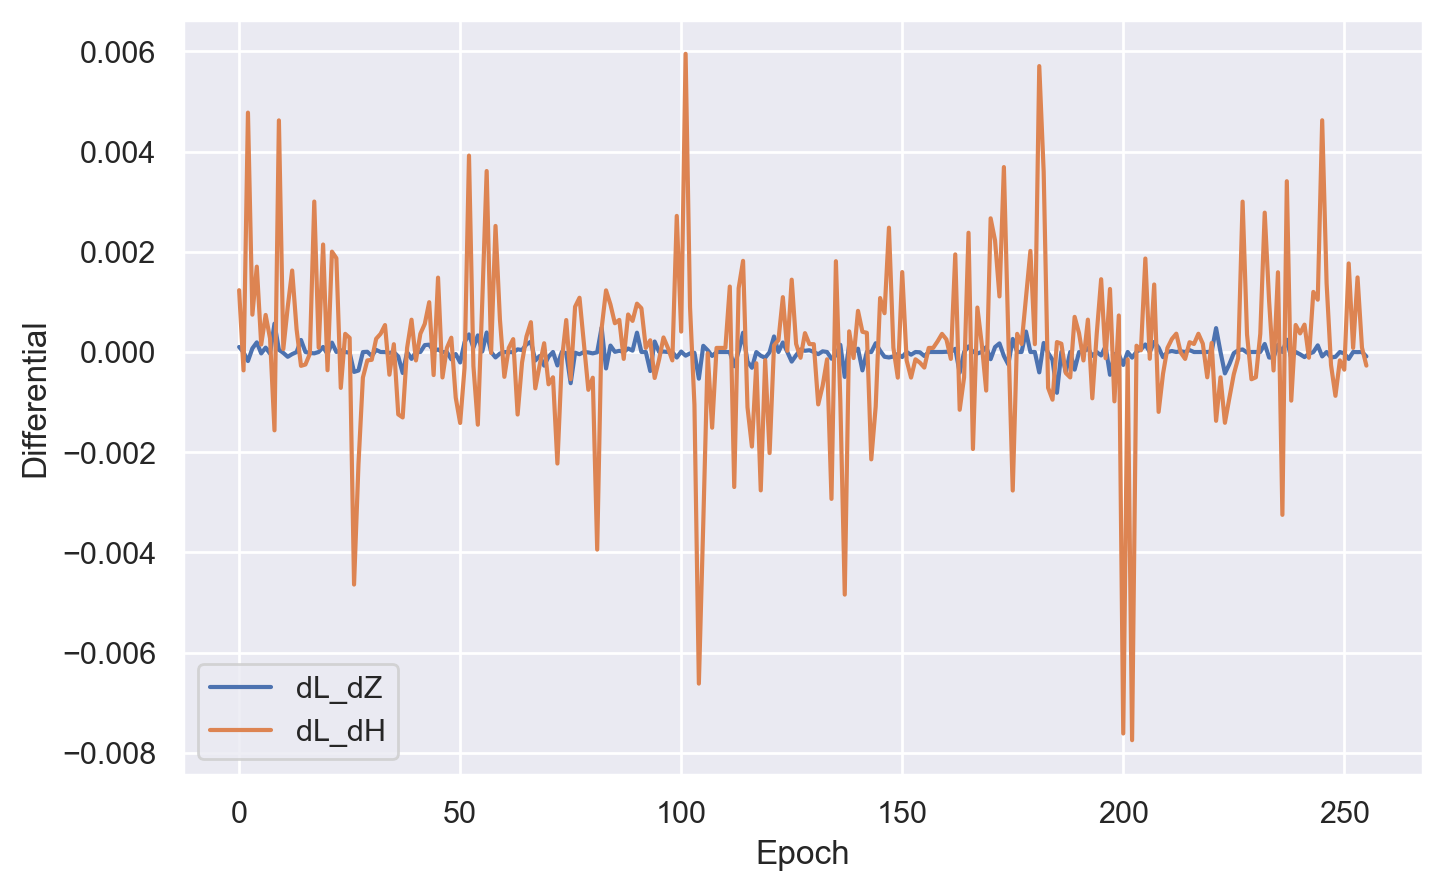

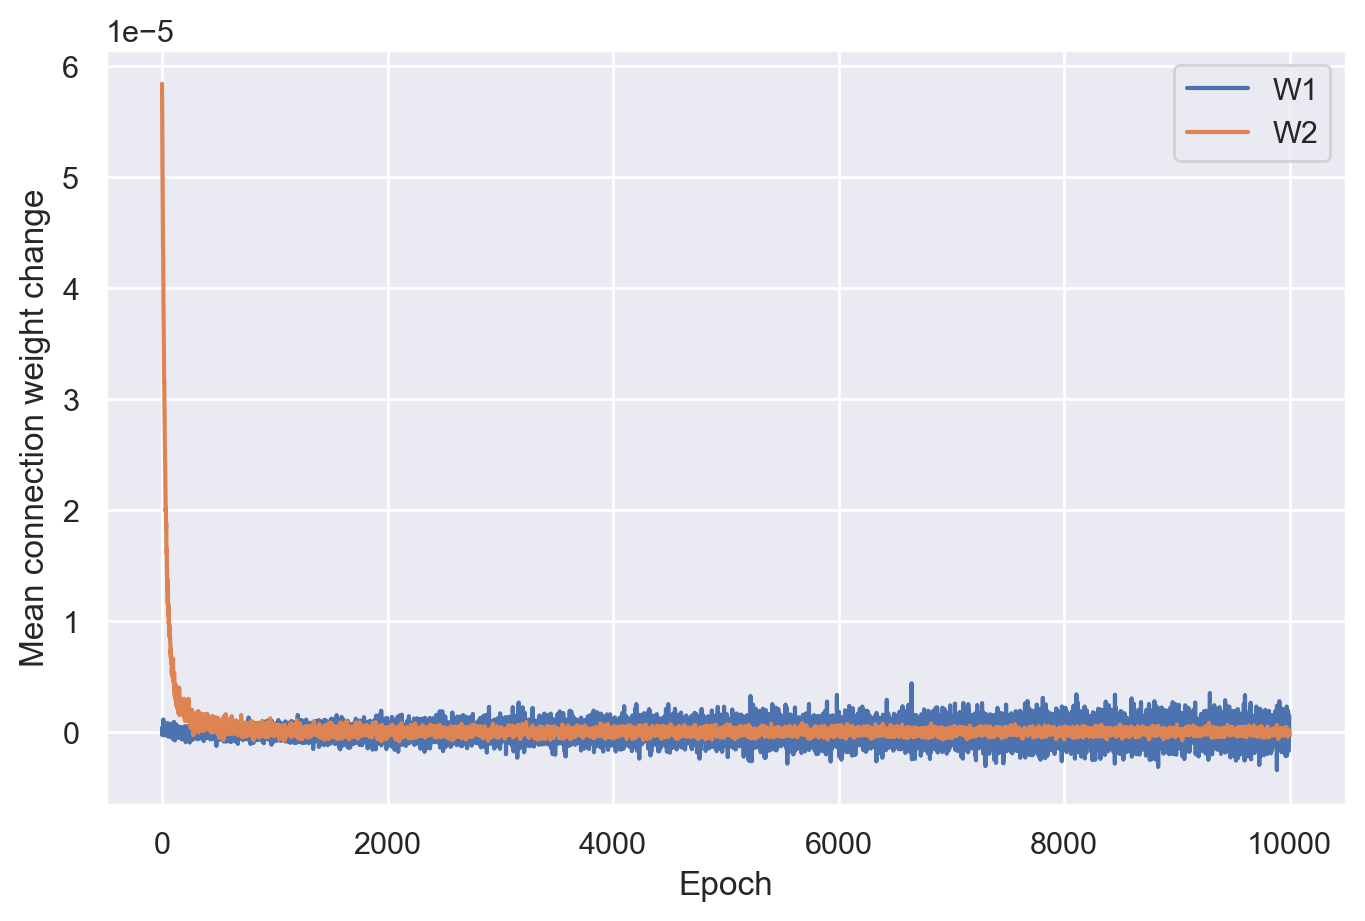

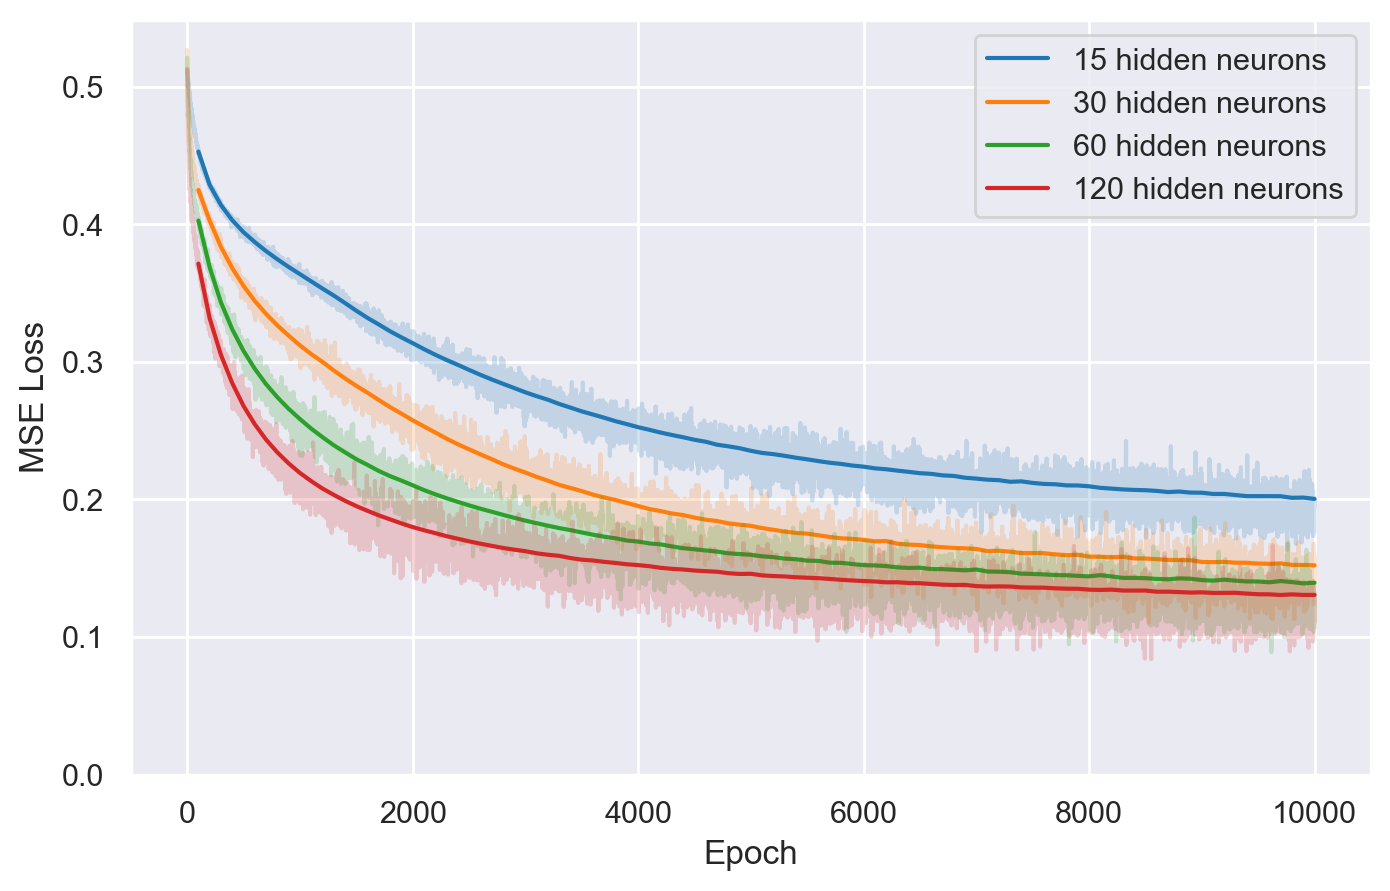

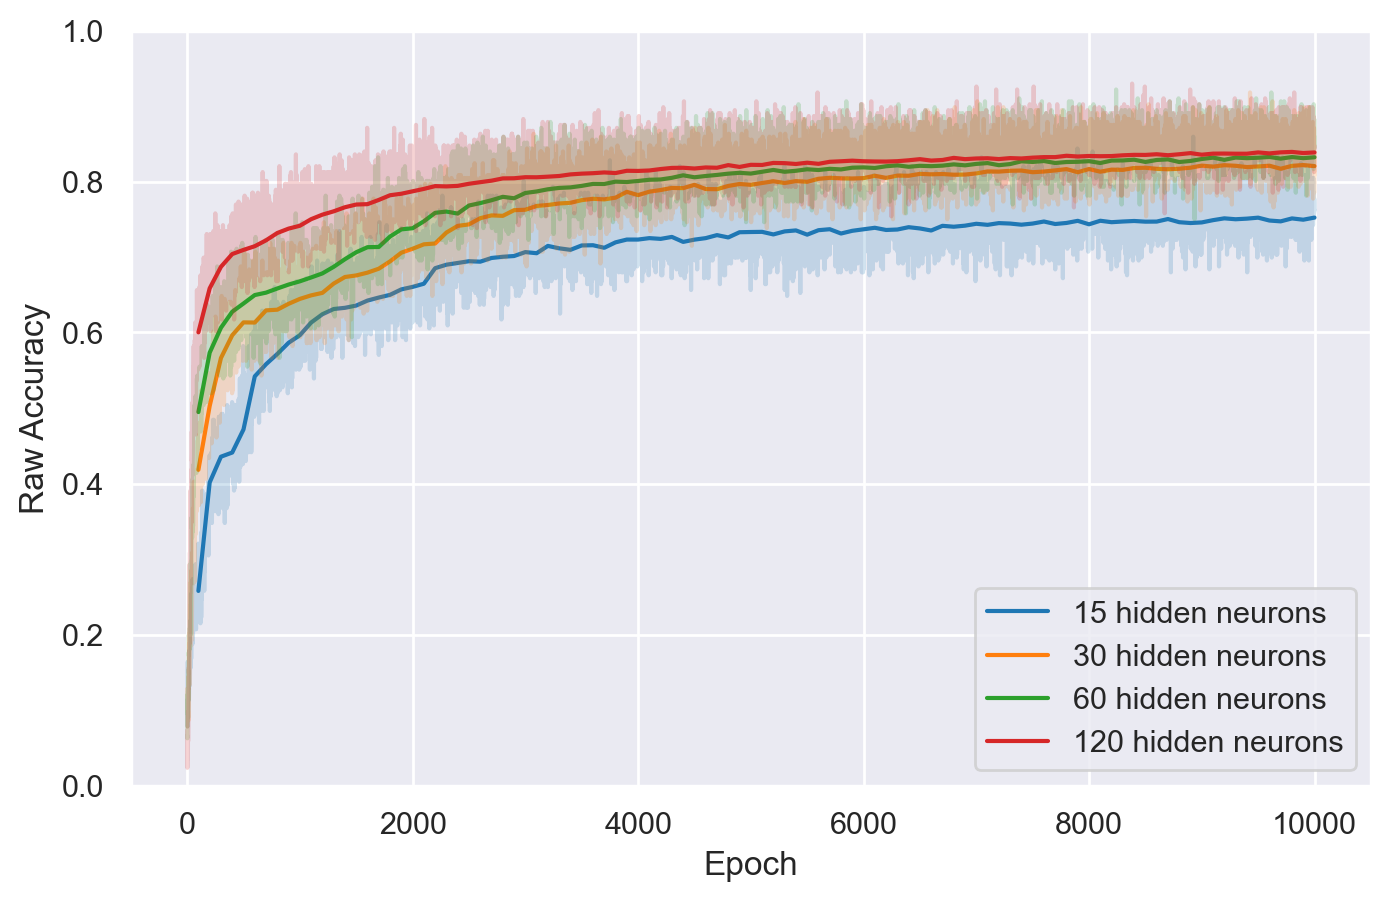

In [116]:
plot_inbetweens([results_60["gradient_terms"]], [""])
plot_weights([results_60["weights"]], ["weights"])


plot_loss(
    [
        results_15["loss"], 
        results_30["loss"], 
        results_60["loss"], 
        results_120["loss"]
    ], [
        '15 hidden neurons', 
        '30 hidden neurons', 
        '60 hidden neurons', 
        '120 hidden neurons',
    ]
)

plot_accuracy(
    [
        results_15["accuracy"], 
        results_30["accuracy"], 
        results_60["accuracy"], 
        results_120["accuracy"]
    ], [
        '15 hidden neurons', 
        '30 hidden neurons', 
        '60 hidden neurons', 
        '120 hidden neurons',
    ]
)